In [1]:
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

sys.path.append("..")
from src.utils.io import get_path, var_to_str
from src.utils.config import L2_REG
from src.utils.data import load_dataset
from src.optim.objective import squared_error_loss

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 26
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['text.usetex'] = True

In [3]:
out_path="../results/"
l2_reg = L2_REG

In [4]:
def get_weights(optimizer, objective, dataset):
    model_cfg = {"objective": objective, "l2_reg": l2_reg, "loss": "squared_error", "n_class": None}
    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=out_path)
    return pickle.load(open(os.path.join(path, "best_weights.p"), "rb"))

def get_losses(optimizer, objective, dataset):
    X_train, y_train, X_val, y_val = load_dataset(dataset, data_path="../data/")
    w = get_weights(optimizer, objective, dataset)
    return squared_error_loss(w, X_val, y_val).detach().numpy()

In [5]:
colors = {
    "erm": "tab:red", 
    "superquantile": "tab:blue", 
    "extremile": "tab:purple", 
    "esrm": "tab:green",
    "superquantile_hard": "tab:blue", 
    "extremile_hard": "tab:purple", 
    "esrm_hard": "tab:green",
    "superquantile_lite": "tab:blue", 
    "extremile_lite": "tab:purple", 
    "esrm_lite": "tab:green",
}

titles = {
    "superquantile": "0.5-Superquantile", 
    "extremile": "2-Extremile", 
    "esrm": "1-ESRM",
    "superquantile_hard": "0.75-Superquantile", 
    "extremile_hard": "2.5-Extremile", 
    "esrm_hard": "2-ESRM",
    "superquantile_lite": "0.25-Superquantile", 
    "extremile_lite": "1.5-Extremile", 
    "esrm_lite": "0.5-ESRM",
}

In [6]:
def create_ax(ax, objective, losses, trim=5, normalize=False):
    if trim:
        diffs = (np.sort(losses["erm"]) - np.sort(losses[objective]))[trim:-trim]
    else:
        diffs = (np.sort(losses["erm"]) - np.sort(losses[objective]))
    if normalize:
        diffs /= losses["erm"].std()
    for i, diff in enumerate(diffs):
        if diff > 0:
            ax.vlines((i + 1) / len(diffs), ymin=0.0, ymax=diff, color=colors[objective])
        else:
            ax.vlines((i + 1) / len(diffs), ymin=diff, ymax=0.0, color=colors[objective])

In [7]:
def create_plot(objectives, optimizer="lsvrg"):
    sns.set_style("white")

    fig, axes = plt.subplots(4, 3, figsize=(24, 24), sharey="row")

    trim = 0
    normalize = True
    datasets = ["simulated", "yacht", "energy", "concrete"]

    for i, dataset in enumerate(datasets):
        losses = {
            "erm": get_losses(optimizer, "erm", dataset)
        }
        for j, objective in enumerate(objectives):
            losses[objective] = get_losses(optimizer, objective, dataset)
            create_ax(axes[i, j], objective, losses, trim=trim, normalize=normalize)

    for i, dataset in enumerate(datasets):
        axes[i, 0].set_ylabel(r"ERM Quantiles $-$ L-Risk Quantiles " + f"({dataset})", fontsize=18)
        axes[i, 0].set_ylabel(f"{dataset}", fontsize=23)

    for j, objective in enumerate(objectives):
        axes[0, j].set_title(titles[objective], fontsize=34)
        axes[len(datasets) - 1, j].set_xlabel(f"Probability under Empirical CDF")

    fig.suptitle(r"ERM Loss Quantiles $-$ L-Risk Loss Quantiles", fontsize=36, y=0.94)

    # axes[0].set_yticks([])
    if "_lite" in objectives[1]:
        suffix = "_lite"
    elif "_hard" in objectives[1]:
        suffix = "_hard"
    else:
        suffix = ""
    plt.savefig(f"../figures/uci_risk_diff{suffix}.pdf", bbox_inches="tight")
    plt.show()

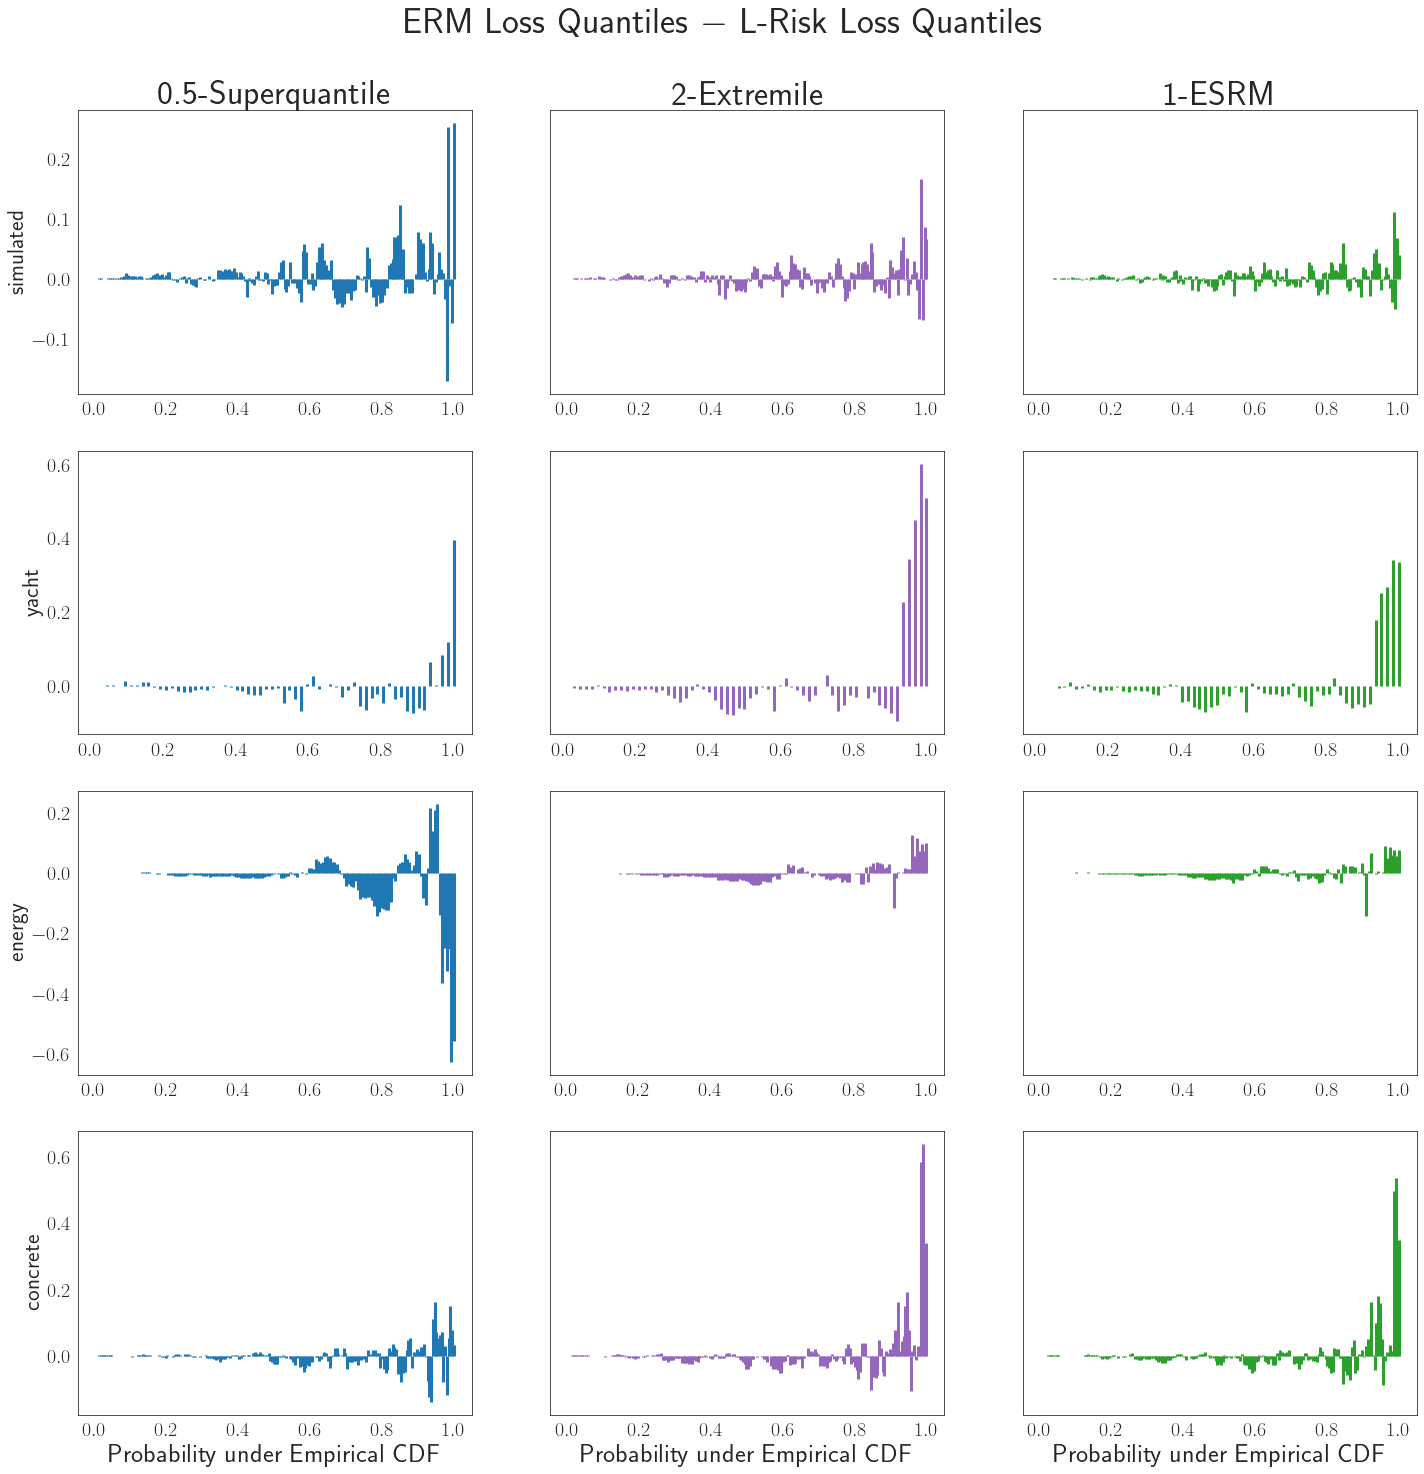

In [8]:
objectives = ["superquantile", "extremile", "esrm"]
create_plot(objectives)

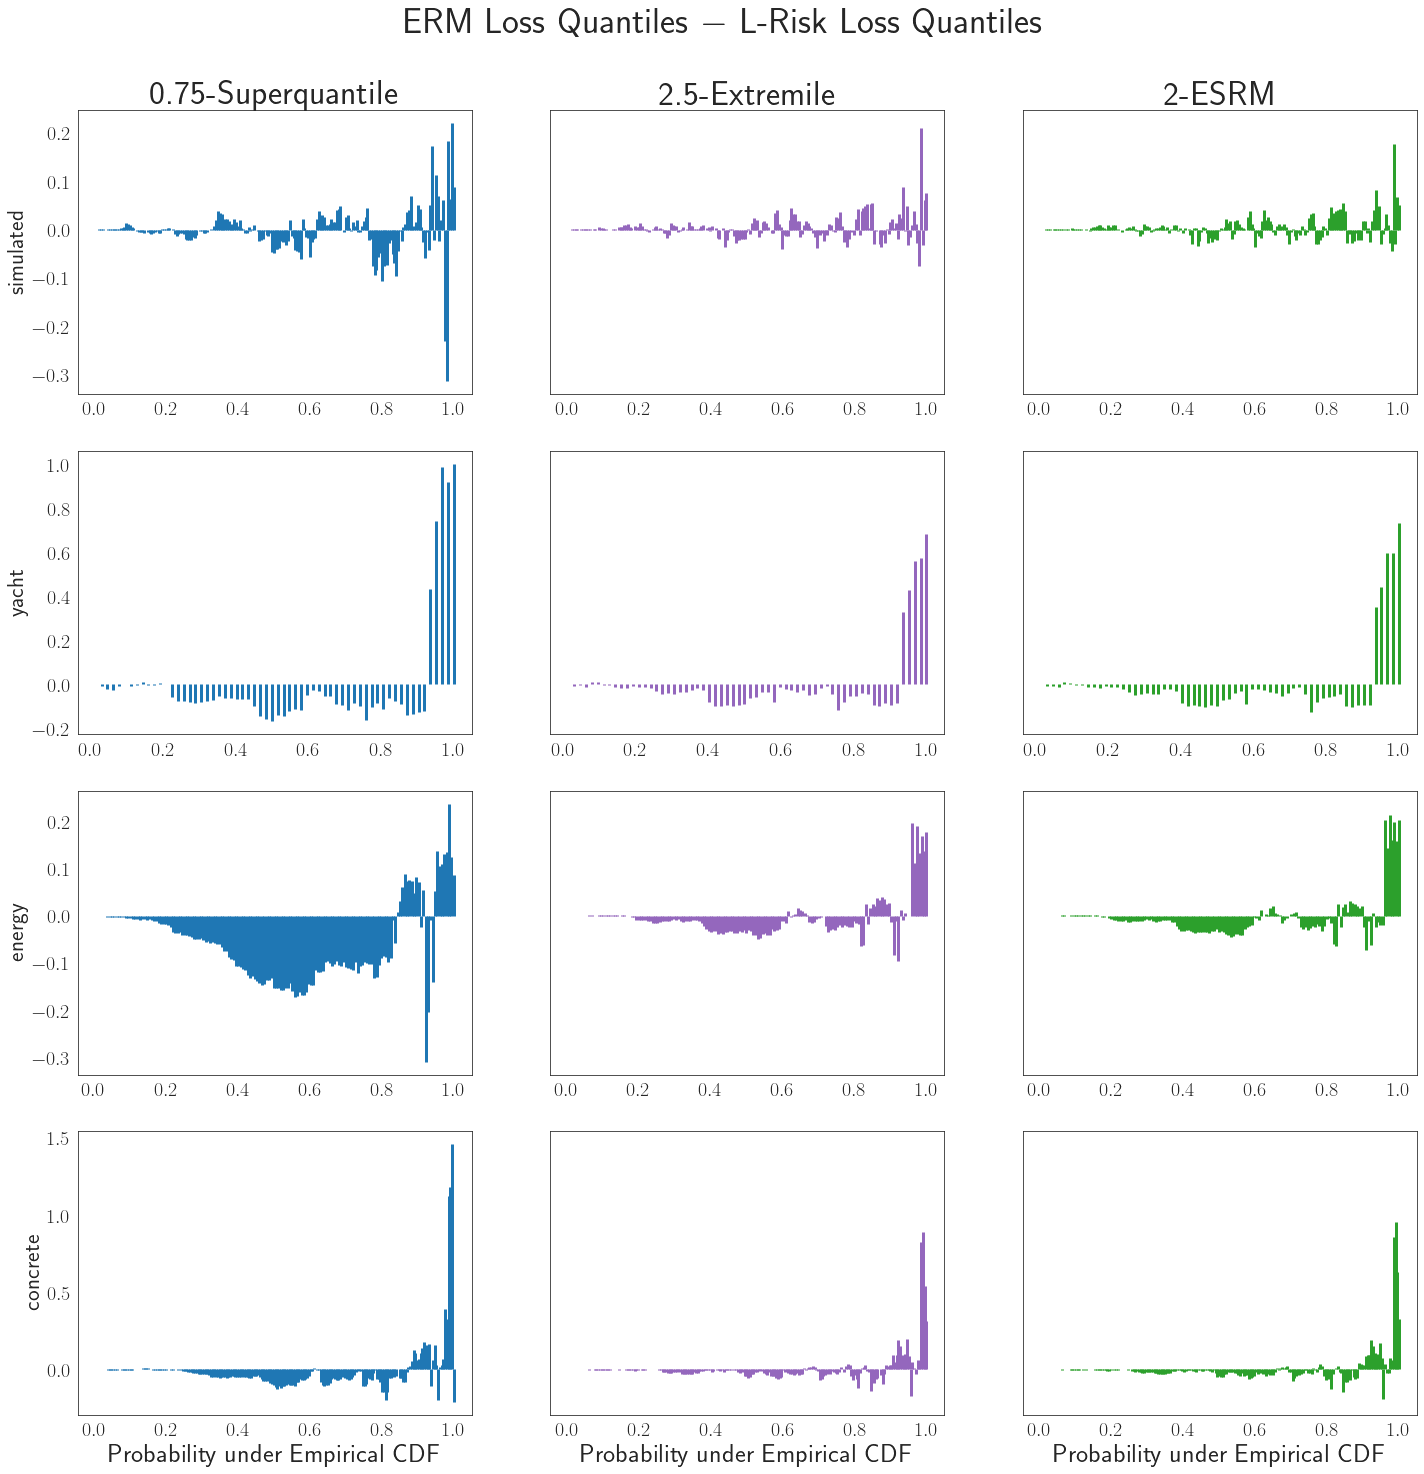

In [9]:
objectives = ["superquantile_hard", "extremile_hard", "esrm_hard"]
create_plot(objectives)

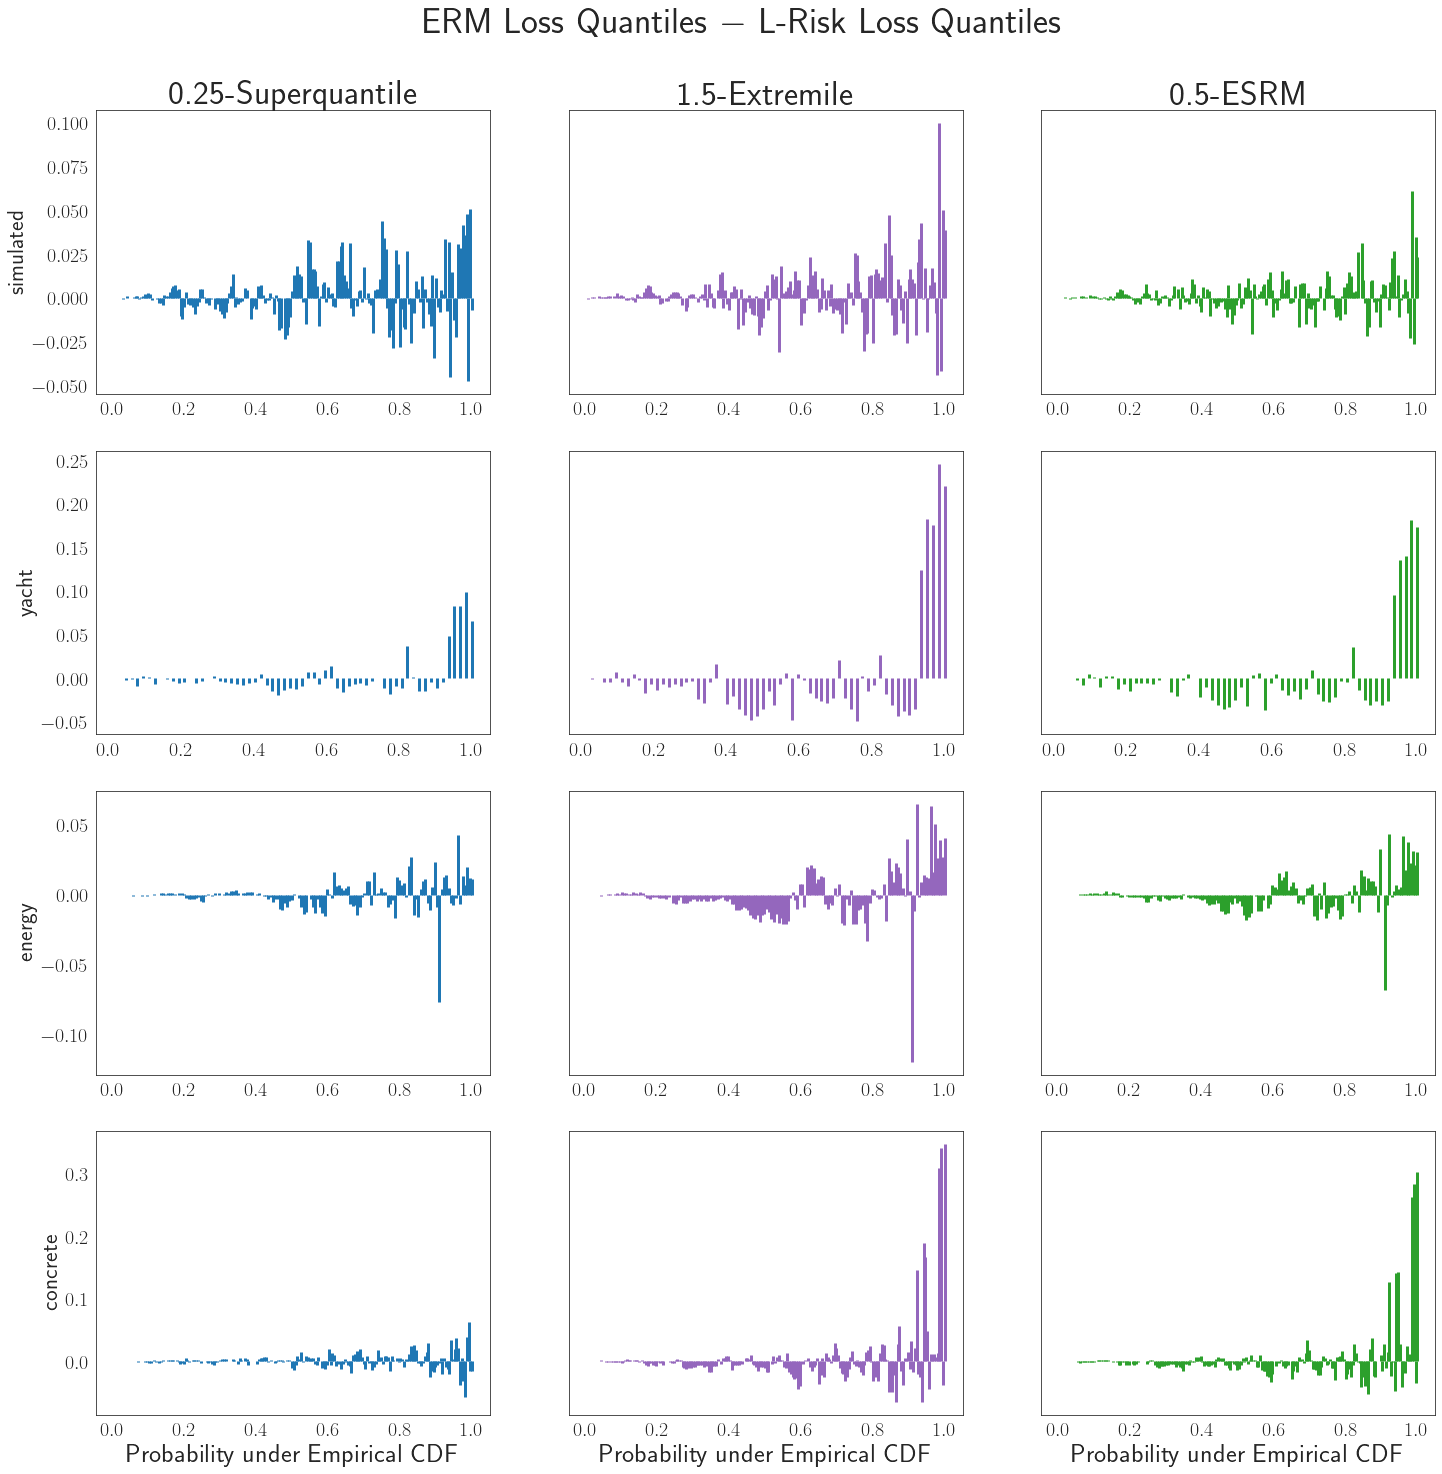

In [10]:
objectives = ["superquantile_lite", "extremile_lite", "esrm_lite"]
create_plot(objectives)